Basics of Dask Array
=============

This notebook goes through the basics of using `dask.array`.  We do the following

0.  [Create a fake dataset and store it in an HDF5 file](#Create-Fake-dataset)
1.  [Load data from an HDF5 file](#Load-data-from-HDF5-file)
2.  [Perform basic array operations](#Perform-Basic-Array-Computations)
3.  [Compute results](#Output-Results)


## 0: Create Fake dataset

We create an artificial dataset to play with.  We use dask.array to create this dataset and then store into an HDF5 file.

In [1]:
!rm -f myfile.hdf5

import dask.array as da

x = da.fromfunction(lambda i, j, k: i + j + k**2, chunks=(5, 512, 512), shape=(100, 2048, 2048), dtype='f8')
x.to_hdf5('myfile.hdf5', '/x', compression='lzf', shuffle=True)

1: Load data from HDF5 file
----------------------------

Now we imagine that we are given the HDF5 file produced above.  We learn how to interact with this data using `dask.array`.

First we interact with the HDF5 file with the Python library [`h5py`](http://www.h5py.org/).   H5Py provides a no-nonsense Python view of HDF5 files.  `Dask.array` complements `h5py` by adding computation.

In [2]:
import h5py
f = h5py.File('myfile.hdf5')
dset = f['/x']
dset

<HDF5 dataset "x": shape (100, 2048, 2048), type "<f8">

This is an `h5py.Dataset` object.  We can slice into it to get numpy arrays out but can't otherwise perform computation.

We use the [dask.array.from_array](http://dask.pydata.org/en/latest/array-api.html#dask.array.core.from_array) function to wrap any numpy-like object with dask.array.  We provide two arguments

1.  The object `dset`
2.  A chunk shape that specifies how we want to break up our large array.  In this case we choose the chunkshape found in the h5py dataset itself.

In [3]:
dset.chunks

(5, 512, 512)

In [4]:
import dask.array as da
x = da.from_array(dset, chunks=(5, 512, 512))
x

dask.array<from-ar..., shape=(100, 2048, 2048), dtype=float64>

2: Perform Basic Array Computations
-------------------------------------

Our dask array behaves mostly like a normal NumPy array.  We can slice into it, perform arithmetic, reductions, etc. with the same syntax used by numpy.

The main difference is that we'll need to add a `.compute()` to our final result.

In [5]:
a = x[0, :5, :5]
b = x[:, :5, :5]
c = a - b.mean()

c.compute()

array([[-57.5, -56.5, -53.5, -48.5, -41.5],
       [-56.5, -55.5, -52.5, -47.5, -40.5],
       [-55.5, -54.5, -51.5, -46.5, -39.5],
       [-54.5, -53.5, -50.5, -45.5, -38.5],
       [-53.5, -52.5, -49.5, -44.5, -37.5]])

The intermediate results (like a, b, c) are all `da.Array` objects, not NumPy arrays.  The `.compute()` method transforms `da.Array` objects into `np.ndarray` objects.

In [6]:
b  # b is a lazily evaluated da.Array

dask.array<getitem..., shape=(100, 5, 5), dtype=float64>

Most numpy operations remain available to you.  

See the [scope](http://dask.pydata.org/en/latest/array-api.html#dask.array.core.from_array) and [API](http://dask.pydata.org/en/latest/array-api.html) documentation for a complete list.

In [7]:
(da.sin(x[0])**2 + da.cos(x[0].T)**2).mean(axis=0)

dask.array<atop-2b..., shape=(2048,), dtype=float64>

3: Output Results
----------------

After doing our heavy computation or data reduction in `dask.array` we would like to either store our results on disk, or transfer our smaller results to numpy arrays so that we can interact with the rest of the PyData ecosystem.

*  Use `.compute()` to create a numpy array
*  Use [`.to_hdf5()`](http://dask.pydata.org/en/latest/array-api.html#dask.array.core.Array.to_hdf5) or [`.store()`](http://dask.pydata.org/en/latest/array-api.html#dask.array.core.store) to store to disk
*  Depend upon the `__array__` protocol for automatic conversion with other projects.



### Use `.compute()` to craete a numpy array

As we've already seen, the `.compute()` method performs computation and turns our lazily evaluated `da.Array` into a NumPy ndarray.

In [8]:
y = (da.sin(x[0])**2 + da.cos(x[0].T)**2).mean(axis=0)
y

dask.array<atop-2b..., shape=(2048,), dtype=float64>

In [9]:
result = y.compute()
result

array([ 0.99411711,  0.97851761,  1.02392765, ...,  1.00357197,
        0.97418835,  1.01793332])

In [10]:
type(result)

numpy.ndarray

### Store in HDF5 files

You can store your result back in HDF5 files with the `.to_hdf5` method.

In [11]:
y.to_hdf5('myfile.hdf5', '/y')
f['/y']

<HDF5 dataset "y": shape (2048,), type "<f8">

### Store in anything that supports numpy slicing

Dask.array can read or write to anything that supports numpy-style slicing using the functions [`da.from_array`](http://dask.pydata.org/en/latest/array-api.html#dask.array.core.from_array) and [`da.store`](http://dask.pydata.org/en/latest/array-api.html#dask.array.core.store).  

In the example below we use a proper numpy array `output` but this could be any object that follows slicing rules including NetCDF datasets, BColz carrays, numpy memmap files, etc..

In [12]:
import numpy as np
output = np.empty(shape=(2048,), dtype='f8')
y.store(output)
output

array([ 0.99411711,  0.97851761,  1.02392765, ...,  1.00357197,
        0.97418835,  1.01793332])

### Plot with Matplotlib

Because `da.Array` objects implement the `__array__` protocol they often *just work* with other libraries in the ecosystem.  In the example below we drop `da.Array` objects directly into matplotlib functions.

In [13]:
from matplotlib.pyplot import imshow, plot
%matplotlib inline

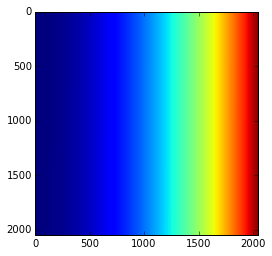

In [14]:
imshow(x.mean(axis=0))

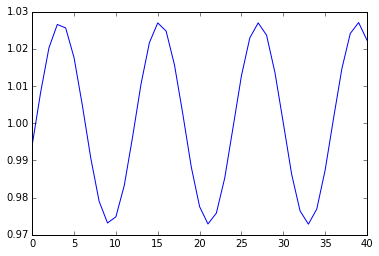

In [15]:
plot((da.sin(x[0])**2 + da.cos(x[0].T)**2).mean(axis=0)[::50])